# Retrieve underlying RICs of chain RIC

## Method 1) Get chain constituents with Refinitiv Websocket API
a WebSocket connection can be made to connect with Refinitiv Real-Time Distribution Systems, RTDS (version 3.2.1 (and higher) where this transport is enabled), and, Refinitiv Real-Time - Optimized, RTO (cloud solution) available via Refinitiv Data Platform (RDP). In this article, we are going to make a connection to the latter one (RTO).
Process of this application is as a diagram below

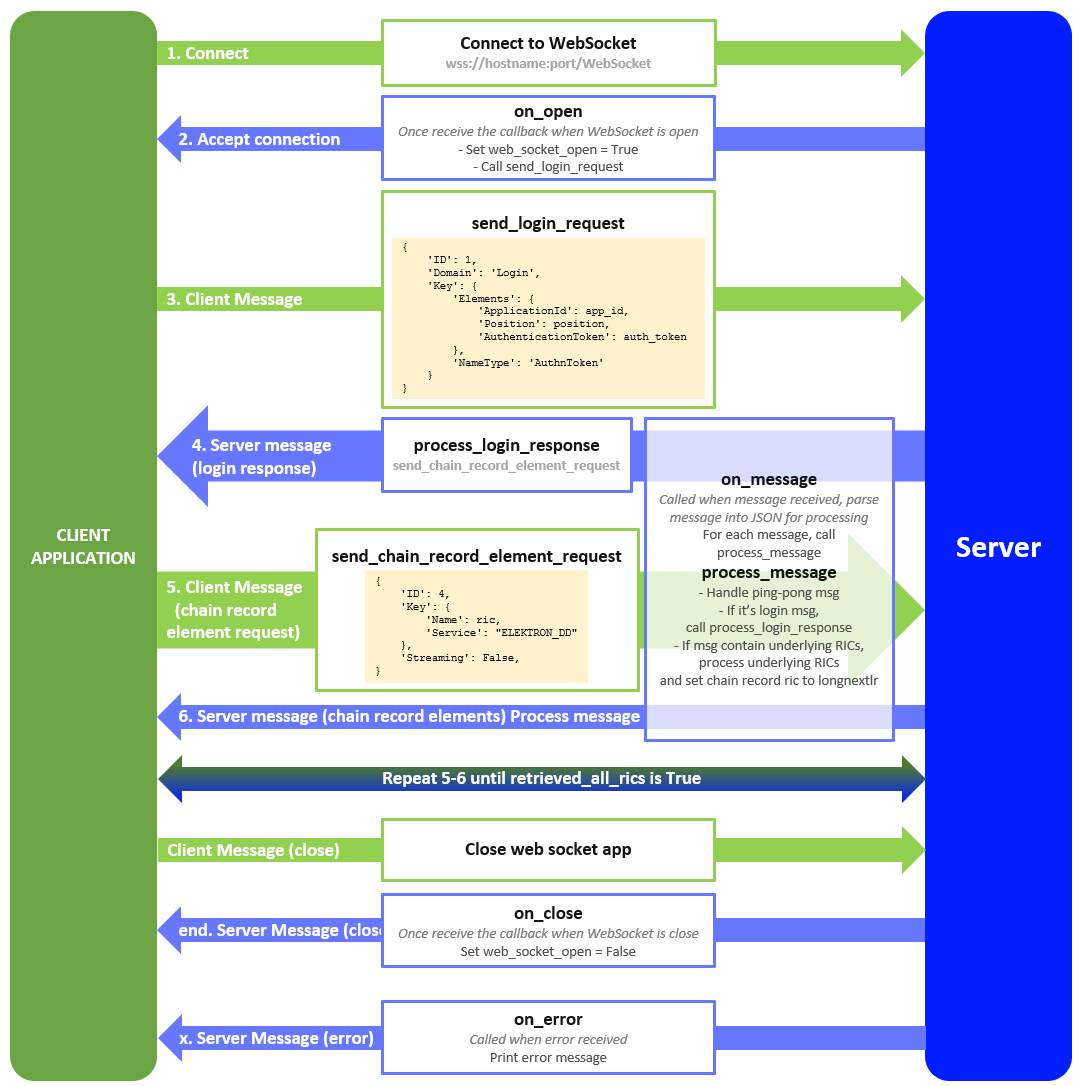

In [1]:
import rdpToken
import requests, json, time, getopt, configparser
from datetime import datetime, timedelta
import websocket, socket
import threading
from threading import Thread, Event
import time

# Websocket - RTO Constants
service_discovery_url = 'https://api.refinitiv.com/streaming/pricing/v1/?transport=websocket'
hostname = ''
port = ''
app_id = '123'
auth_token = ''

position = socket.gethostbyname(socket.gethostname())
snapshot = True # True for non-streaming request

base_ric = '0#.FTSE' # chain RIC used to retrieve the data
all_underlying_rics = [] # to store the result

# other application variable
retrieved_all_rics = False
web_socket_app = None
web_socket_open = False

In [2]:
def set_rto_host_port(auth_token):
    global hostname, port
    
    payload={}
    headers = {
      'Authorization': 'Bearer ' + auth_token
    }

    response = requests.request("GET", service_discovery_url, headers=headers, data=payload)

    hostname = response.json()['services'][0]['endpoint']
    port = response.json()['services'][0]['port']
    
    print(f'Retrieved RTO host: {hostname}:{port}')
    
# Send a Login request - for RDP
def send_login_request(ws):
    """ Generate a login request and send """
    # Set common values for RDP login
    # Note StreamID is 1
    login_json = {
        'ID': 1,
        'Domain': 'Login',
        'Key': {
            'Elements': {
                'ApplicationId': '',
                'Position': ''
            }
        }
    }
    login_json['Key']['Elements']['ApplicationId'] = app_id
    login_json['Key']['Elements']['Position'] = position

    # RDP login request authentication token
    login_json['Key']['NameType'] = 'AuthnToken'
    login_json['Key']['Elements']['AuthenticationToken'] = auth_token

    ws.send(json.dumps(login_json))

def process_message(ws, message_json):
    global auth_token, retrieved_all_rics

    """ Parse at high level and output JSON of message"""
    message_type = message_json['Type']
    
    # receive refresh message
    if message_type == "Refresh":
        
        # process login response
        if 'Domain' in message_json:
            print('Process Login message')
            message_domain = message_json['Domain']
            if message_domain == "Login":
                process_login_response(ws, message_json)
                
        # process underlying RICs response
        elif 'Fields' in message_json:
            print('Process Fields message (Underlying RICs)')
            message_fields = message_json['Fields']
            for x in range(1,15):
                current_field = 'LONGLINK{}'.format(x)
                value = message_fields[current_field]
                if value is not None:
                    all_underlying_rics.append(value)
            longnextlr = message_fields['LONGNEXTLR']
            
            # if reached the last chain record, set retrieved_all_rics flag
            if longnextlr is None:
                print('All underlying RICs are retrieved')
                retrieved_all_rics = True
            # if not reached the last chain record yet, request longnextlr as a next chain record
            else:
                send_chain_record_element_request(ws, longnextlr)
    
    # receive ping message
    elif message_type == "Ping":
        pong_json = { 'Type':'Pong' }
        ws.send(json.dumps(pong_json))
        print("SENT: Pong")

def process_login_response(ws, message_json):
    """ Send item request """
    send_chain_record_element_request(ws, base_ric)

def send_chain_record_element_request(ws, longnextlr):
    """ Create and send simple Market Price request """
    
    mp_req_json = {
        'ID': 4,
        'Key': {
            'Name': longnextlr,
            'Service': "ELEKTRON_DD"
        },
        'Streaming': not snapshot,
    }

    ws.send(json.dumps(mp_req_json))
    print("SENT request of RIC:" + longnextlr)

def on_message(ws, message):
    """ Called when message received, parse message into JSON for processing """
    print("RECEIVED: message")
    message_json = json.loads(message)

    for singleMsg in message_json:
        process_message(ws, singleMsg)

def on_error(ws, error):
    """ Called when websocket error has occurred """
    print(error)


def on_close(ws, close_status_code, close_msg):
    """ Called when websocket is closed """
    global web_socket_open
    print("WebSocket Closed")
    web_socket_open = False

def on_open(ws):
    """ Called when handshake is complete and websocket is open, send login """

    print("WebSocket successfully connected!")
    global web_socket_open
    web_socket_open = True
    send_login_request(ws)

In [3]:
if __name__ == "__main__":
    auth_token = rdpToken.getToken()
    set_rto_host_port(auth_token)

    # Start websocket handshake
    ws_address = "wss://{}:{}/WebSocket".format(hostname, port)
    print("Connecting to WebSocket " + ws_address + " ...")
    web_socket_app = websocket.WebSocketApp(ws_address, header=['User-Agent: Python'],
                                        on_message=on_message,
                                        on_error=on_error,
                                        on_close=on_close,
                                        subprotocols=['tr_json2'])
    
    # Callback for once websocket is open - which will send the Login request
    web_socket_app.on_open = on_open
    # Create Thread for WebsocketApp processing
    wst = threading.Thread(target=web_socket_app.run_forever)
    wst.start()
    
    try:
        while True:
            if(retrieved_all_rics):
                web_socket_app.close() # Close websocket app once all RICs are retrieved
                break
    except KeyboardInterrupt:
        pass
    finally:
        print(str(len(all_underlying_rics)) + ' underlying RICs are retrieved, which are')
        print(all_underlying_rics)

Existing token read from: token.txt
Retrieved RTO host: ap-northeast-1-aws-1-lrg.optimized-pricing-api.refinitiv.net:443
Connecting to WebSocket wss://ap-northeast-1-aws-1-lrg.optimized-pricing-api.refinitiv.net:443/WebSocket ...
WebSocket successfully connected!
RECEIVED: message
Process Login message
SENT request of RIC:0#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:1#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:2#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:3#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:4#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:5#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:6#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)
SENT request of RIC:7#.FTSE
RECEIVED: message
Process Fields message (Underlying RICs)


## Thank you